In [13]:
# Useful imports
import numpy as np, matplotlib.pyplot as plt
import sys; sys.path.append('./')
import sim_models
from data_loader import DataLoader
import emcee, corner
from sklearn.covariance import EmpiricalCovariance
import numpy.linalg as lin
import seaborn as sns
from autocorr_time import integrated_time

In [14]:
# Which data to load?
# E_min : [0.676, 0.84 , 1.269, 1.741, 2.12 , 2.609, 2.609, 3.586, 4.332, 5.475]
# E_max : [0.706, 0.868, 1.292, 1.759, 2.137, 2.624, 2.624, 3.598, 4.342, 5.484]
E_min = 0.676 # MeV
E_max = 2.624 # MeV
which_data = 'som'

# Select the parameterization
# parameterization = 'init-f-wave'
parameterization = 'sim_bs_C'

# Use theory cov?
use_theory_cov = True

# # Information about the sampling
# n_burn = 50000
# n_steps = 200000

number = 0
titles = ['SONIK Data 0.676 MeV - 2.624 MeV\nWith theory covariance']

# Samples file
numbers = 0
# file_name = './05_24_2024/run{}/samples_{}.npz'.format(numbers, numbers)
file_name = './../simultaneous_sampler/runs/tests/test/samples.npz'

# Plot things?
plot_trace = False
plot_prob = False

# Set a specific prior? (Default set: None)
param_bounds = None
params_prior = None

# Correlation matrix (only ERPs vs. include all ERPs + norm)
just_ERPs = True

# Plot cross sections?
# If true, this takes a long time if they are not precomputed
plot_cs = True
# Cross sections file (If I precompute them)
cross_section_file = None


In [15]:
loader = DataLoader(E_min, E_max, which_data)

data = loader.get_data()
norm_group = loader.get_normalization_grouping()
gauss_prior_f = loader.get_normalization_prior_info()

In [16]:
if parameterization == 'sim_bs_C':
    labels = ['$\\bar{c}^{2}$', '$\Lambda_{B}$', '$A_{0}$', '$r_{0}$', '$(C_{1}^{+})^{2}$', '$P_{1}^{+}$', '$(C_{1}^{-})^{2}$', '$P_{1}^{-}$']
    if param_bounds is None:
        param_bounds = np.array([[-0.02, 0.06], [-3, 3], [5.0, 25.0], [-6, 6], [5.0, 25.0], [-6, 6]])
    if params_prior is None:
        params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [13.84, 1.63], [0.0, 1.6], [12.59, 1.85], [0.0, 1.6]]) # center, width
    gauss_prior_params = np.hstack([param_bounds, params_prior])
    model = sim_models.Sim_BS_C(data, norm_group, gauss_prior_params, gauss_prior_f, use_theory_cov)
else:
    sys.stderr.write('Nothing else is implemented yet...')
    sys.exit(-1)

# Add normalization labels
if labels is not None:
    for i in range(0, int(np.max(norm_group) + 1)):
        labels.append('$f_{}$'.format(i))

In [17]:
model.cs_data.shape

(293,)

In [18]:
# Load in the samples
all_samples = np.load(file_name)['arr_0']

samples_not_flat = all_samples[0] # Just the beta = 1 samples
# Swap axes so it is in the shape (step, walker, parameter)
samples_not_flat = np.swapaxes(samples_not_flat, 0, 1)

# # Reshape the samples
# len0, len1, len2 = samples_not_flat.shape
# samples = np.reshape(samples_not_flat, (len0 * len1, len2))

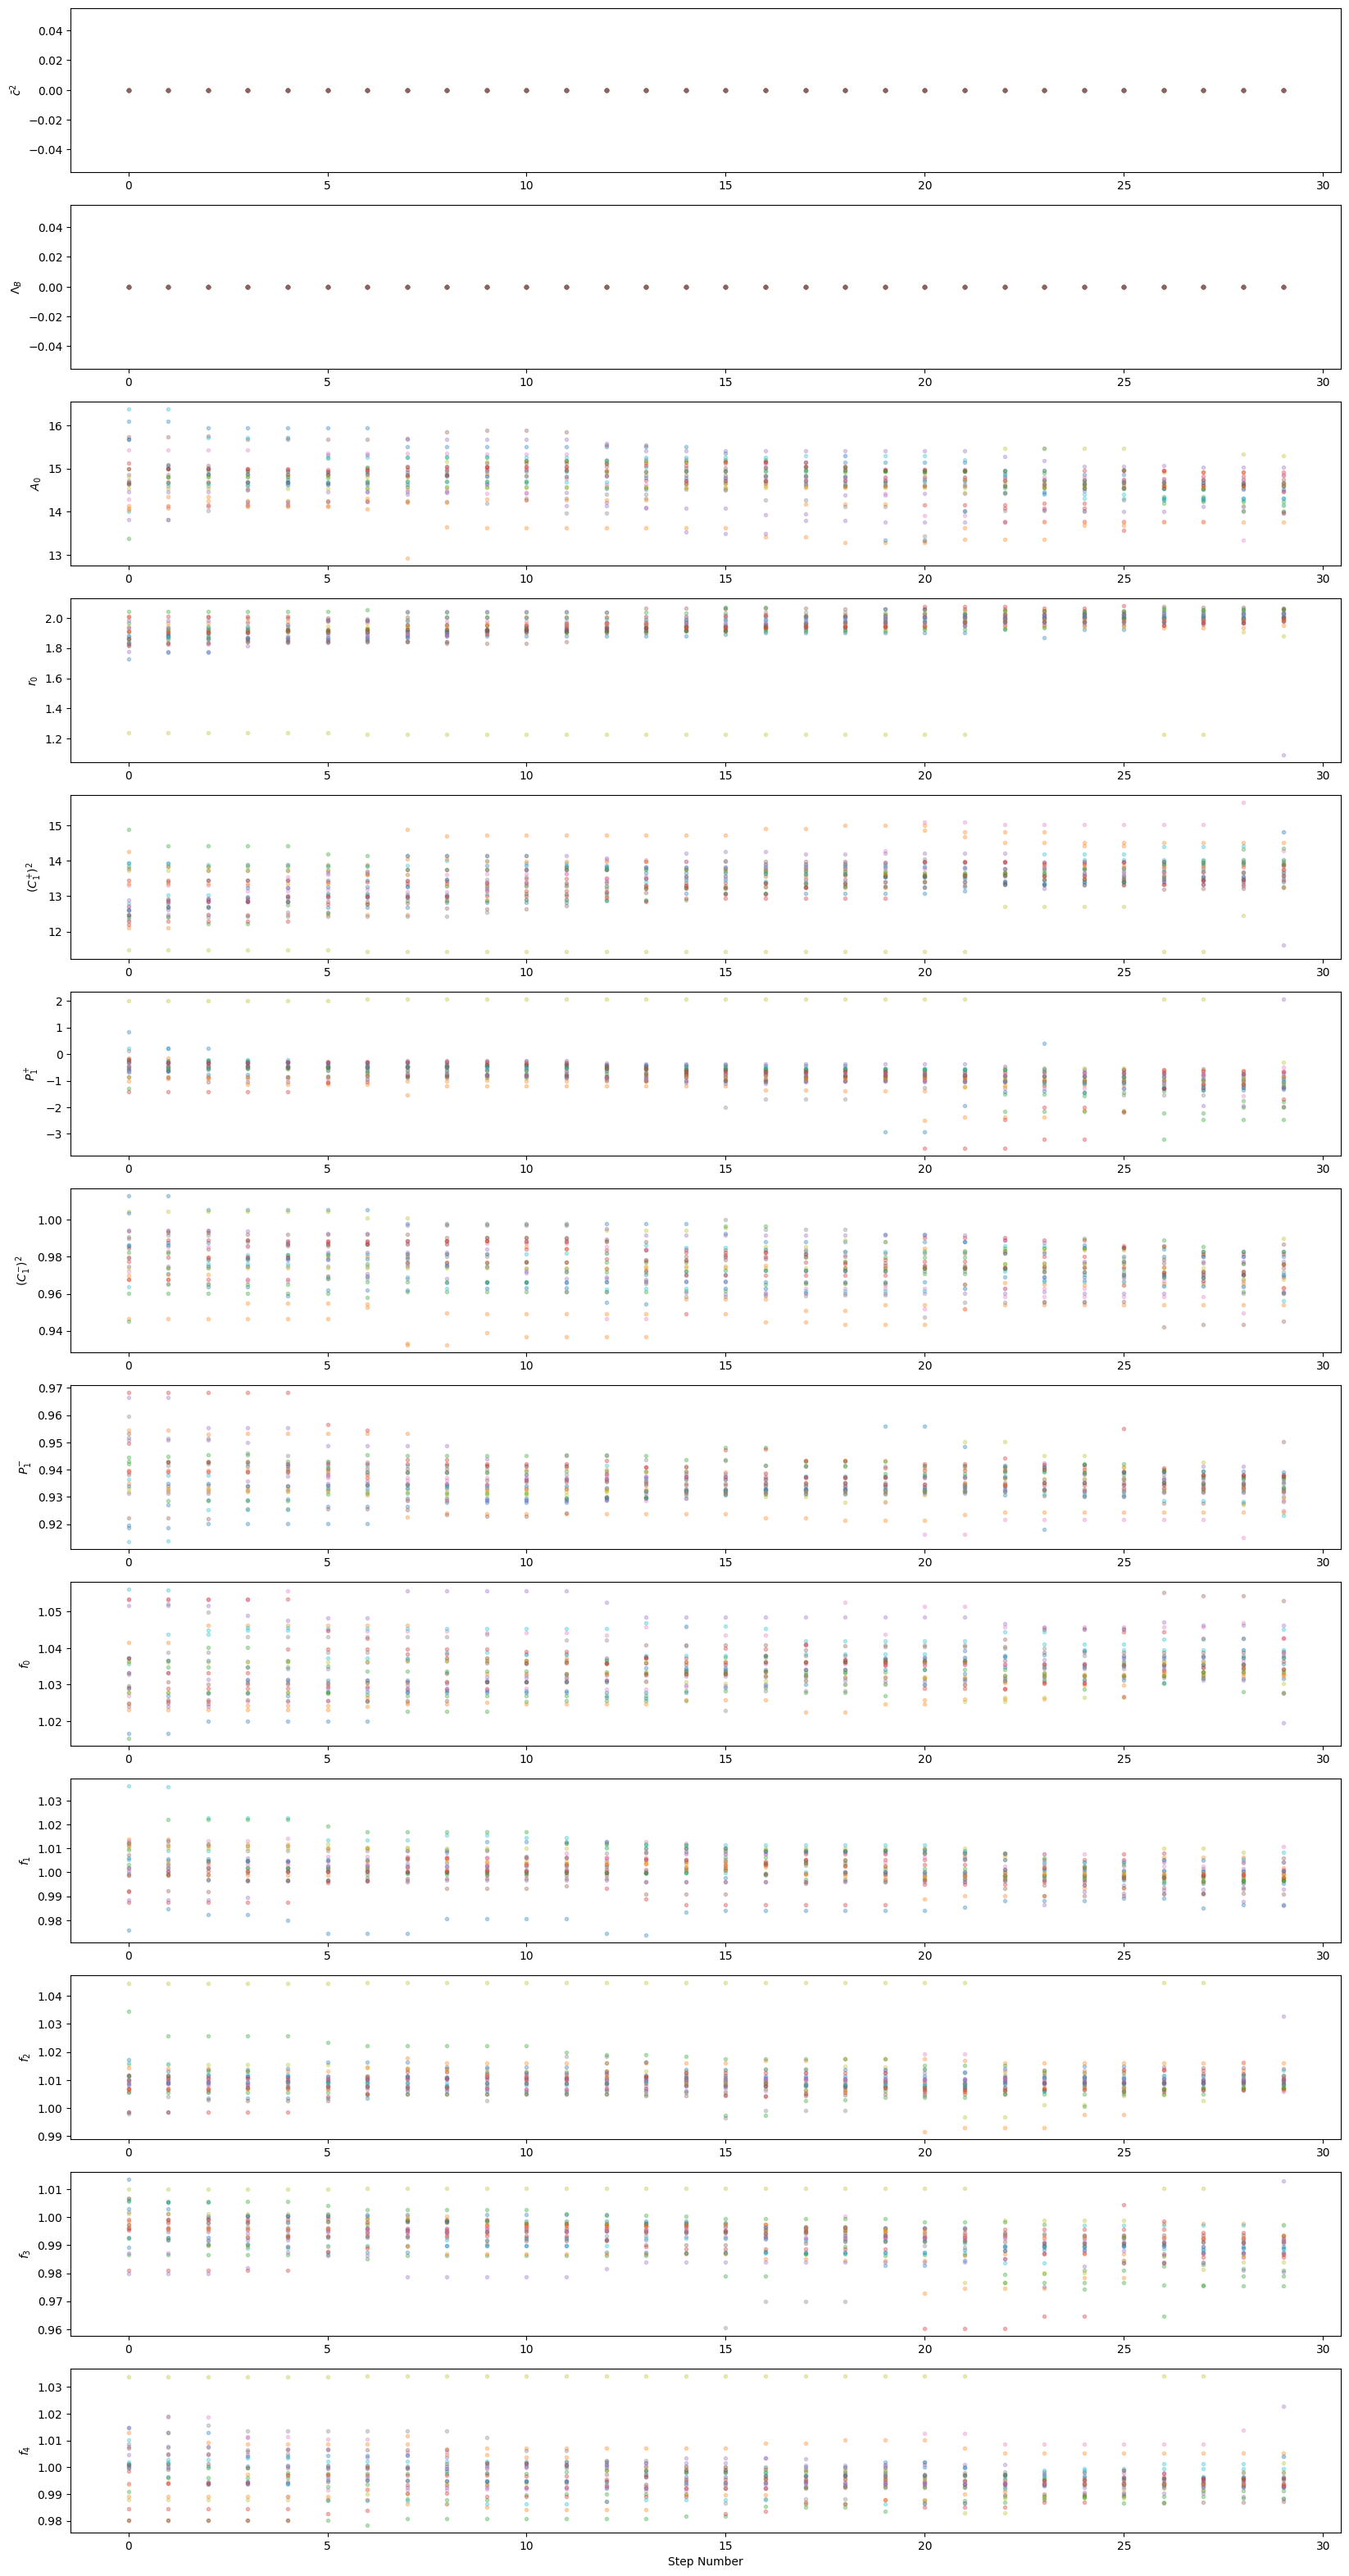

In [19]:
def generate_trace_plot(samples_not_flat):
    # Generate the trace plot given a set of samples
    fig, axes = plt.subplots(samples_not_flat.shape[2], figsize = (20, 40))
    for i in range(0, samples_not_flat.shape[2]):
        ax = axes[i]
        for j in range(0, samples_not_flat.shape[1]):
            ax.plot(samples_not_flat[:, :, i][:, j], '.', alpha = 0.3)
        # ax.plot(samples_not_flat[:, :, i][:, 0], '.', alpha = 0.3)
            ax.set_ylabel(labels[i])
    axes[-1].set_xlabel('Step Number')
    plt.show()

generate_trace_plot(samples_not_flat)

In [20]:
# Look at the variances within each chain to determine if the walker is moving enough or if it is stuck.
within_chain_means = np.mean(samples_not_flat[:, :, :], axis = 0)

# Create an empty array of the within chain variances
within_chain_var = np.empty(within_chain_means.shape)

# Run a for loop across all walkers to compute the within chain variance
for i in range(0, within_chain_means.shape[0]):
    within_chain_var[i, :] = np.sum(np.square(within_chain_means[i, :] - samples_not_flat[:, i, :]), axis = 0) / (samples_not_flat.shape[0] // 2)

# Get the typical within chain variance W for each parameter
W = np.median(within_chain_var, axis = 0)


# Now we need to loop over each chain for each parameter to see how it compares to the typical variance
bad_indices = []
ratios = np.empty(within_chain_means.shape)
# Loop over each parameter
for i in range(0, within_chain_means.shape[1]):
    # Loop over the walkers
    for j in range(0, within_chain_means.shape[0]):
        ratio = np.sum(within_chain_var[j, i] / W[i]) / within_chain_means.shape[1]
        ratios[j, i] = ratio

# Sum along each parameter, this value should be very close to 1.0. Select out the bad indices
total_normalized_ratios = np.sum(ratios, axis = 1)
bad_indices = np.where(total_normalized_ratios <= 0.9)[0]
print('Found {} bad walkers at indices:'.format(bad_indices.shape[0]))
print(bad_indices)

if bad_indices.shape[0] != 0:
    # Remove the bad walkers
    samples_not_flat = np.delete(samples_not_flat, bad_indices, axis = 1)

Found 0 bad walkers at indices:
[]


/var/folders/mb/trbrgjlx0bd1gzxf6cd_k2h40000gn/T/ipykernel_10317/460119626.py:22: RuntimeWarning: invalid value encountered in scalar divide
  ratio = np.sum(within_chain_var[j, i] / W[i]) / within_chain_means.shape[1]


In [21]:
# # Artificiallly remove more burnin
# samples_not_flat = samples_not_flat[900:, :, :]
# Flatten the samples
len0, len1, len2 = samples_not_flat.shape
samples = np.reshape(samples_not_flat, (len0 * len1, len2))
print(samples.shape)

(780, 13)


In [22]:
# # Try to compute the autocorrelation times and thin
# ac_s = integrated_time(samples_not_flat)

# print(ac_s)
# ac = int(np.ceil(np.max(ac_s)))
# print('Using {}'.format(ac))
# # samples_not_flat = samples_not_flat[::ac, :, :]

# # print('Warning: chain is shorter than 50 ac times. Not thinning...')

In [23]:
# Flatten the samples
len0, len1, len2 = samples_not_flat.shape
samples = np.reshape(samples_not_flat, (len0 * len1, len2))
print(samples.shape)

(780, 13)


1.0 0.9999999999999999


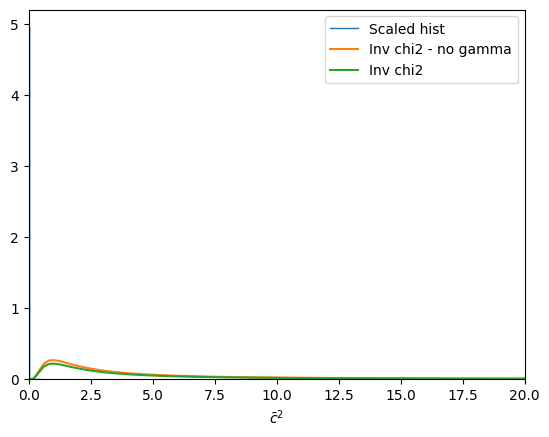

In [24]:
# # # Plots the normalized histogram of c_bar^2 with the priors

from scipy.special import gamma
fig, ax = plt.subplots()
n_bins = 100
plot_min = 0
plot_max = 20
eps = 0.00001

hist_samples = samples[np.where(np.logical_and(samples[:, 0] >= plot_min, samples[:, 0] <= plot_max)), 0]
counts, bins = np.histogram(hist_samples, n_bins, density = True)

inv_chi_2_dist = lambda x: (((1.5**3) / 2)**(1.5/2) / (gamma(1.5/2) * np.power(x, 1 + 1.5/2))) * np.exp(-(1.5**3) / (2 * x))
inv_chi_2_dist_no_gam = lambda x: (((1.5**3) / 2)**(1.5/2) / (np.power(x, 1 + 1.5/2))) * np.exp(-(1.5**3) / (2 * x))
x_s = np.linspace(plot_min + eps, plot_max, n_bins)

A = 1 / np.trapz(inv_chi_2_dist_no_gam(x_s), x_s)
B = 1 / (np.trapz(counts, x_s))

print(np.trapz(B * counts, x_s), np.trapz(A * inv_chi_2_dist_no_gam(x_s), x_s))

ax.stairs(B * counts, bins, label = 'Scaled hist')
ax.plot(x_s, A * inv_chi_2_dist_no_gam(x_s), label = 'Inv chi2 - no gamma')
ax.plot(x_s, A * inv_chi_2_dist(x_s), label = 'Inv chi2')
ax.set_xlabel('$\\bar{c}^{2}$')
ax.set_xlim(plot_min, plot_max)
ax.legend()

In [25]:
samples.shape

(780, 13)

ValueError: It looks like the parameter(s) in column(s) 0, 1 have no dynamic range. Please provide a `range` argument.

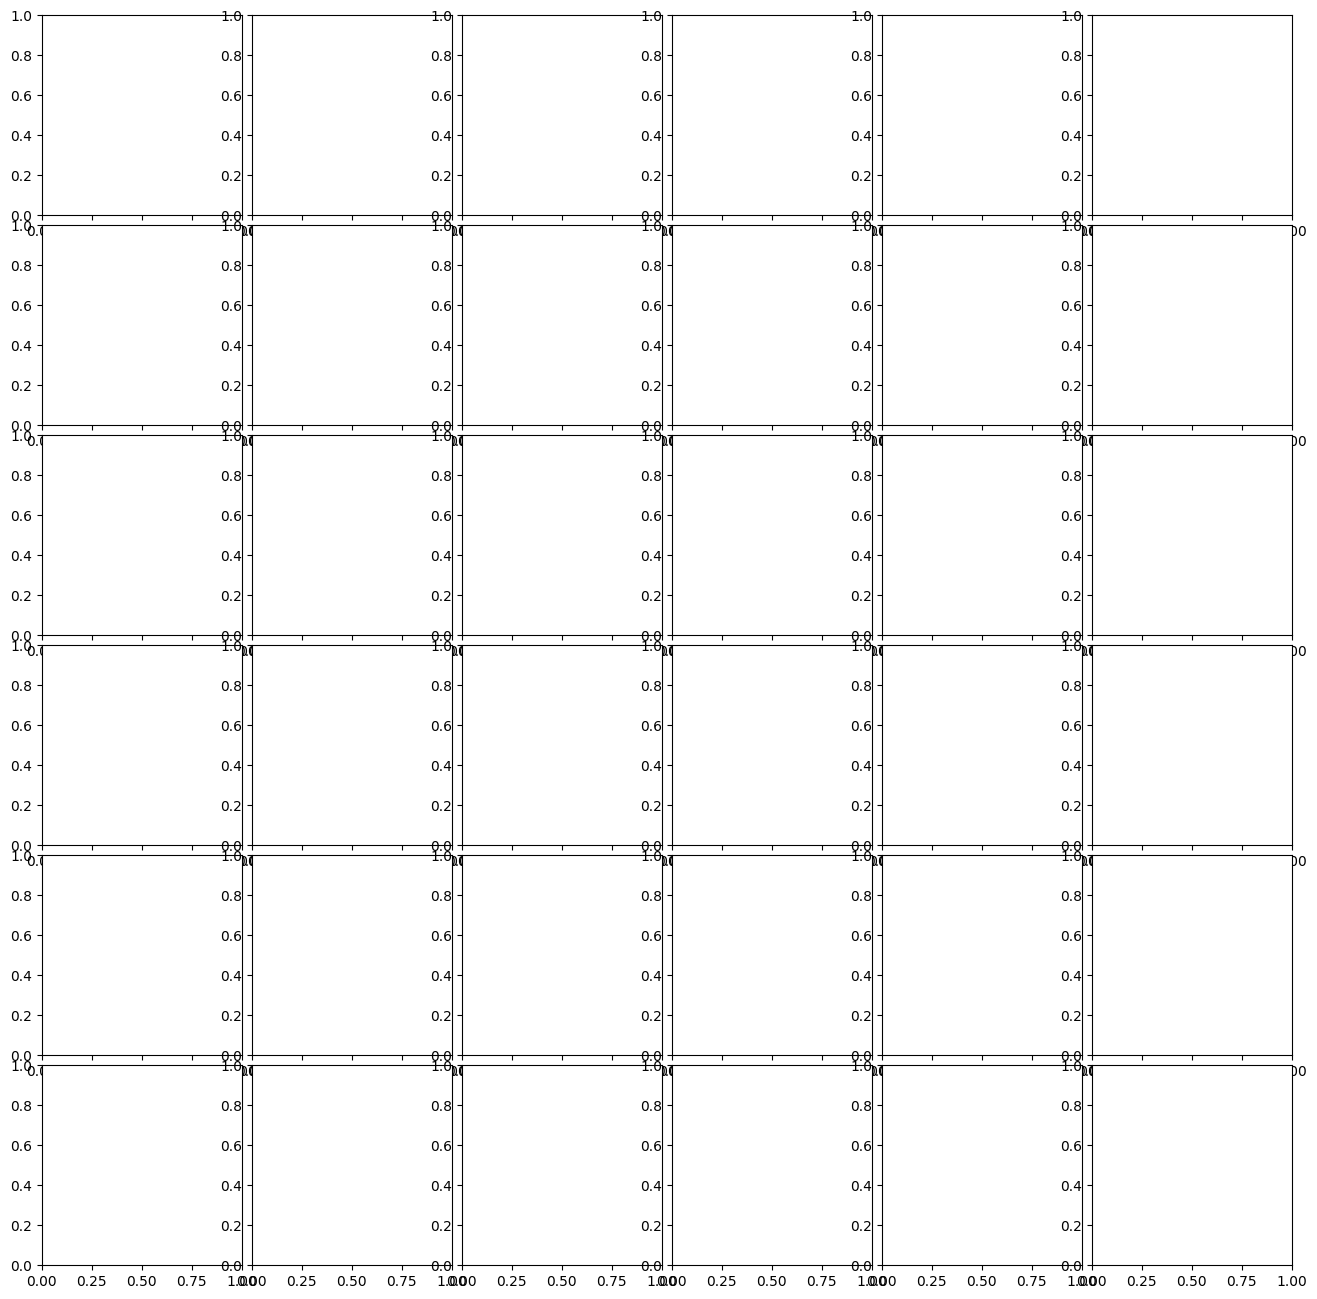

In [27]:
corner.corner(samples[:, :model.erp_dim + 2], labels = labels[:model.erp_dim + 2], quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.suptitle(titles[number], fontsize = 22)
plt.show()

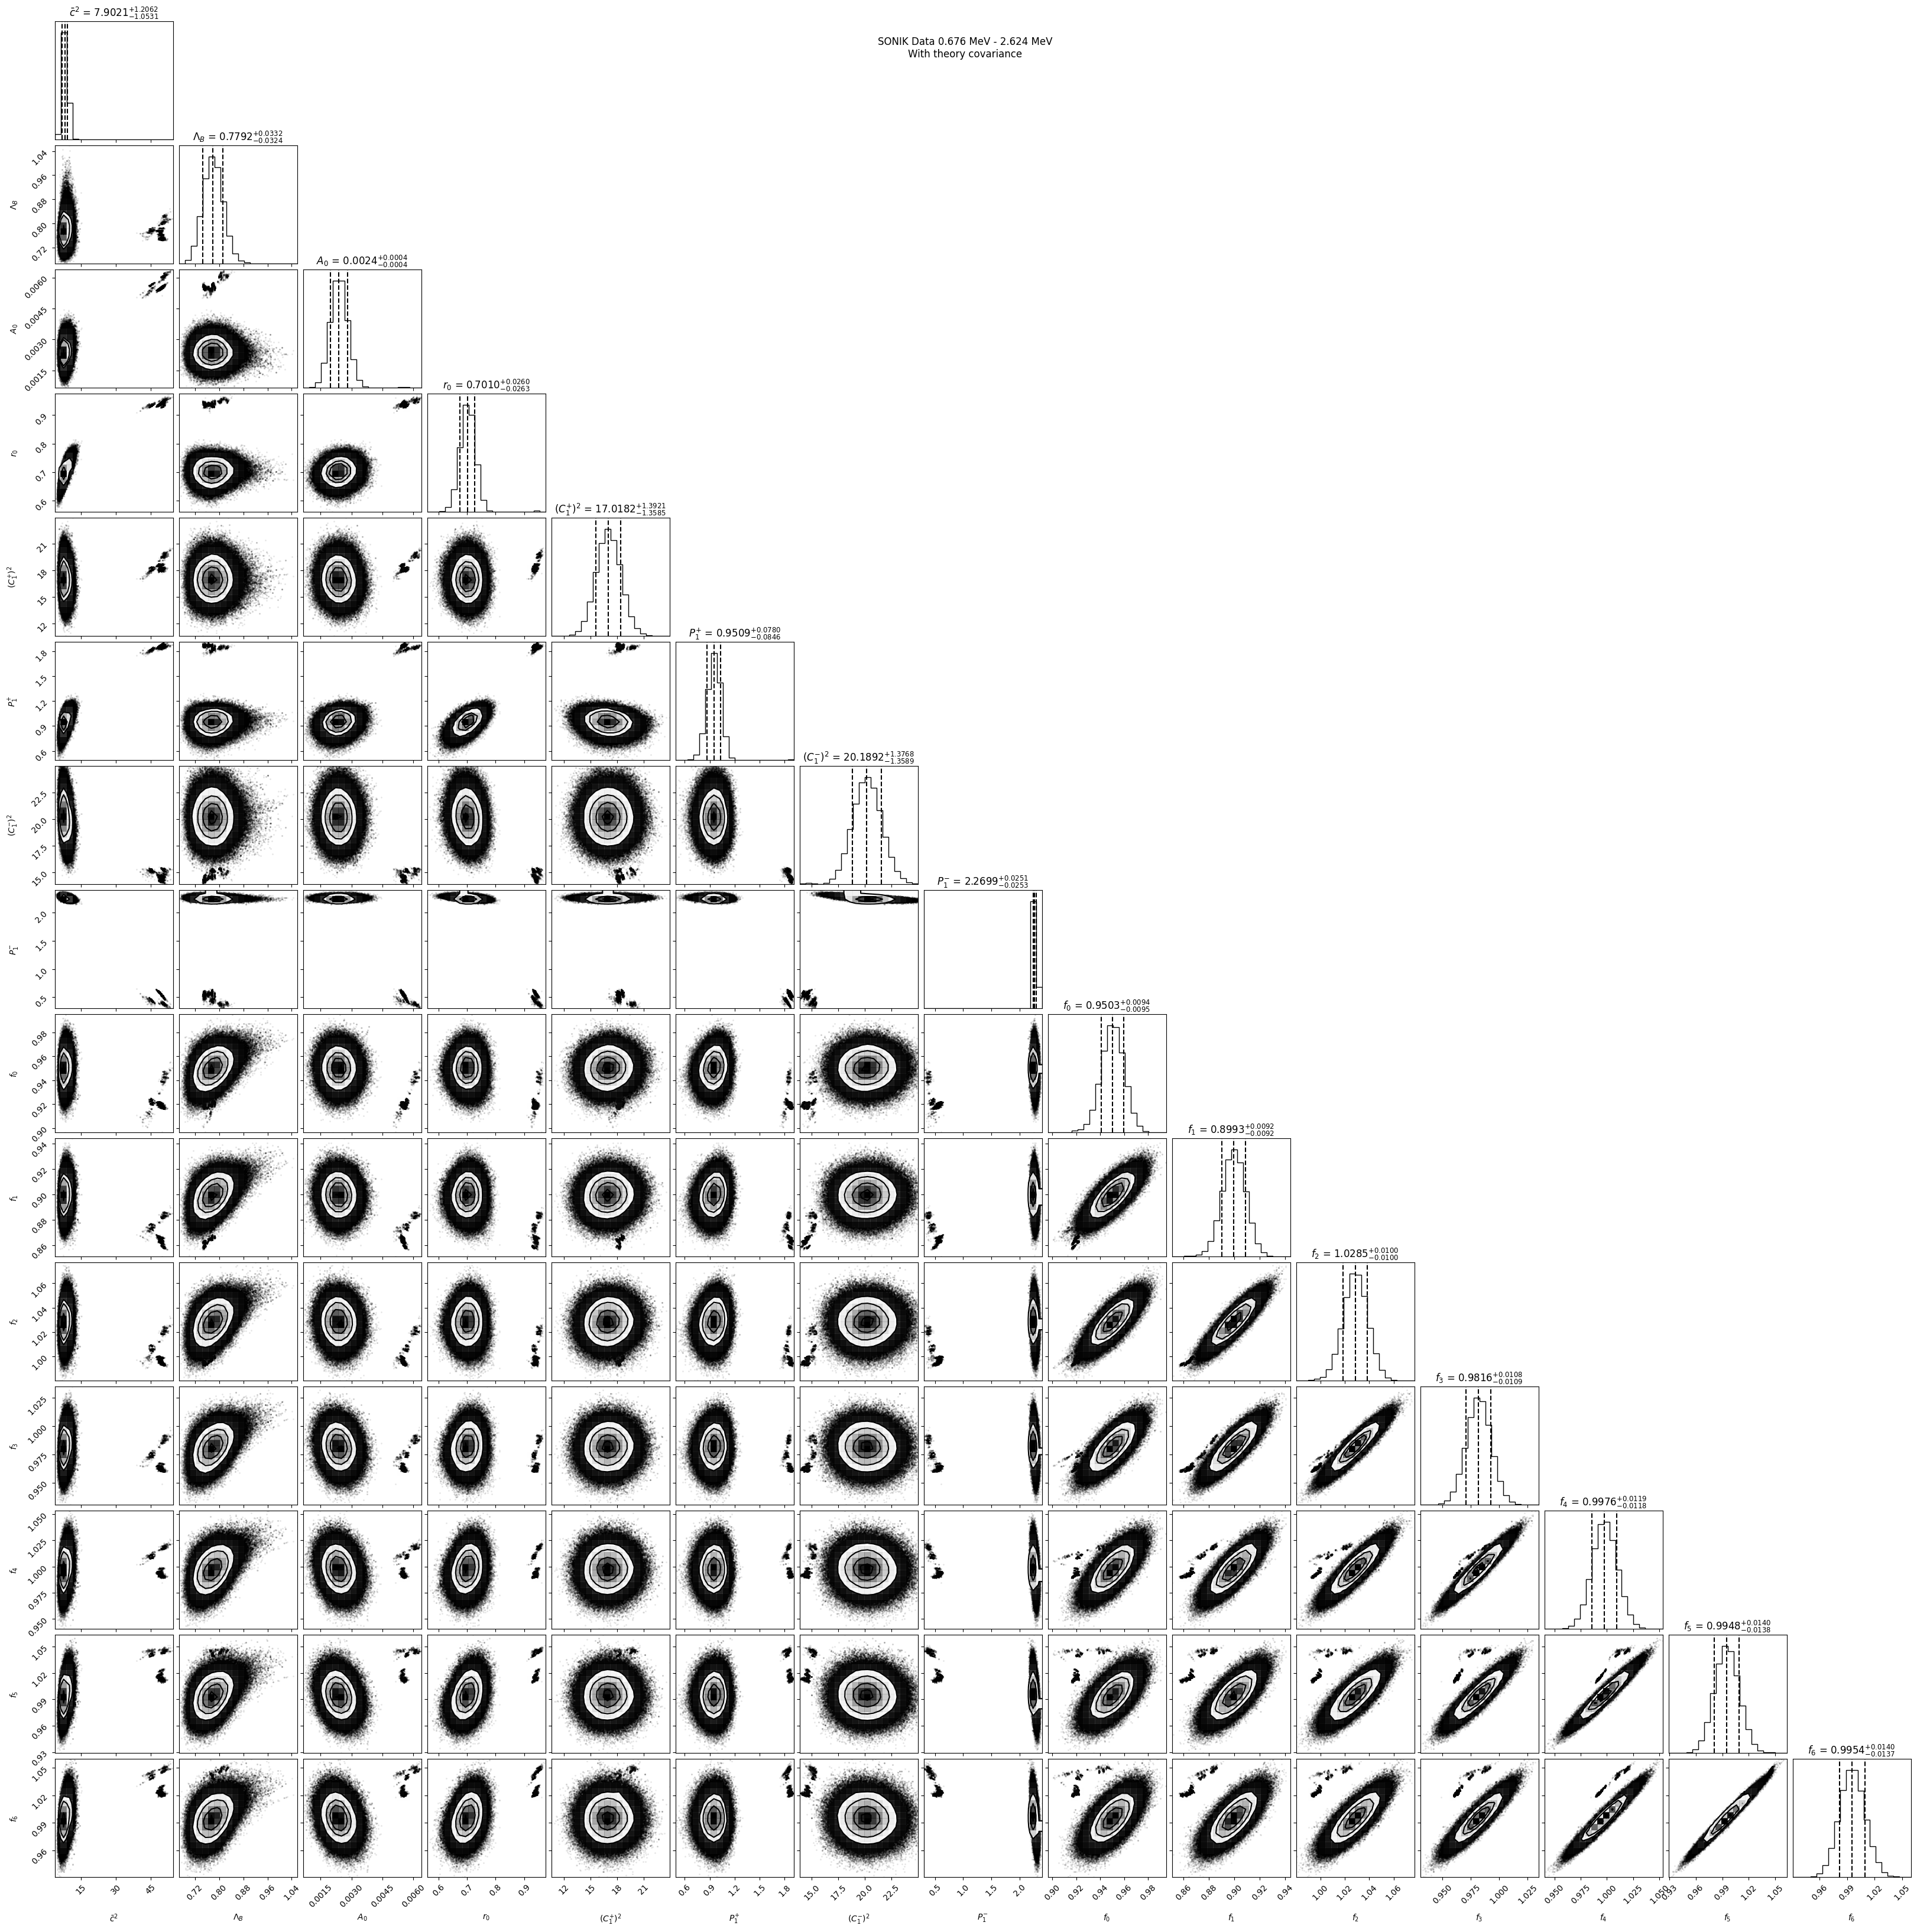

In [ ]:
corner.corner(samples, labels = labels, quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.suptitle(titles[number])
plt.show()

In [ ]:
print(np.quantile(samples[:, :], axis = 0, q = [0.5]))

[[7.90212339e+00 7.79200355e-01 2.37757433e-03 7.00961064e-01
  1.70182477e+01 9.50867724e-01 2.01892297e+01 2.26993919e+00
  9.50300571e-01 8.99332602e-01 1.02851097e+00 9.81623800e-01
  9.97598964e-01 9.94794845e-01 9.95413981e-01]]


In [ ]:
samples.shape

(900000, 15)

In [ ]:
# Set up root path for the data
root_path = './'

# Set up the list of paths to the data
barnard_paths = [root_path + 'barnard_data/barnard5477.txt',
                root_path + 'barnard_data/barnard6345.txt',
                root_path + 'barnard_data/barnard7395.txt',
                root_path + 'barnard_data/barnard9003.txt',
                root_path + 'barnard_data/barnard10460.txt',
                root_path + 'barnard_data/barnard11660.txt',
                root_path + 'barnard_data/barnard12530.txt',
                root_path + 'barnard_data/barnard14080.txt']

som_paths = [root_path + 'SOM/som_cm_int1.npy',
            root_path + 'SOM/som_cm_int2.npy',
            root_path + 'SOM/som_cm_int3.npy']


data_E_max = E_max
data_which_data = which_data


# Load in the data, specific to the set and the E_max

# Handle Barnard set first
barnard_data_list = []
for path in barnard_paths:
    barnard_data_list.append(np.loadtxt(path))

# Handle Som set
som_data_list = []
l_som = [] # For Som normalization
l_som_energies = []
for path in som_paths:
    data_set = np.load(path, allow_pickle = True)
    som_data_list.append(data_set)
    l_som_energies.append([data_set[i][:, 0][0] for i in range(len(data_set))])
    l_som.append([len(data_set[j]) for j in range(len(data_set))])

# Concatenate the datasets into arrays
barnard_data = np.concatenate(barnard_data_list)
som_temp = np.concatenate(np.concatenate(som_data_list)) 
l_som_energies = np.array(l_som_energies)
# 2x concatenate because it is a list of lists

# For some reason, the Som data is formatted [E, theta, cs, err] so I swap the
# columns to match the Barnard set followint [theta, E, cs, err]
som_data = np.column_stack([som_temp[:, 1], som_temp[:, 0], som_temp[:, 2], som_temp[:, 3]])

# Cap the energy at E_max
# NOTE: The Barnard data has lowest E at 2.439 MeV and the Som data has
# lowest E at 0.676 MeV
if data_E_max != None:
    barnard_indices = np.where(barnard_data[:, 1] <= data_E_max)
    som_indices = np.where(som_data[:, 1] <= data_E_max)
    barnard_data = barnard_data[barnard_indices]
    som_data = som_data[som_indices]

# Now select which data to use
if data_which_data == 'both':
    data = np.concatenate([barnard_data, som_data])
elif data_which_data == 'som':
    data = som_data
elif data_which_data == 'barnard':
    data = barnard_data
else:
    sys.stderr.write('Choose a \'which_data\': both, som, barnard...')
    sys.exit(-1)

Number of curves: 36000
Number of figures: 7


TypeError: Sim_BS_C.get_cs_theory() takes 3 positional arguments but 4 were given

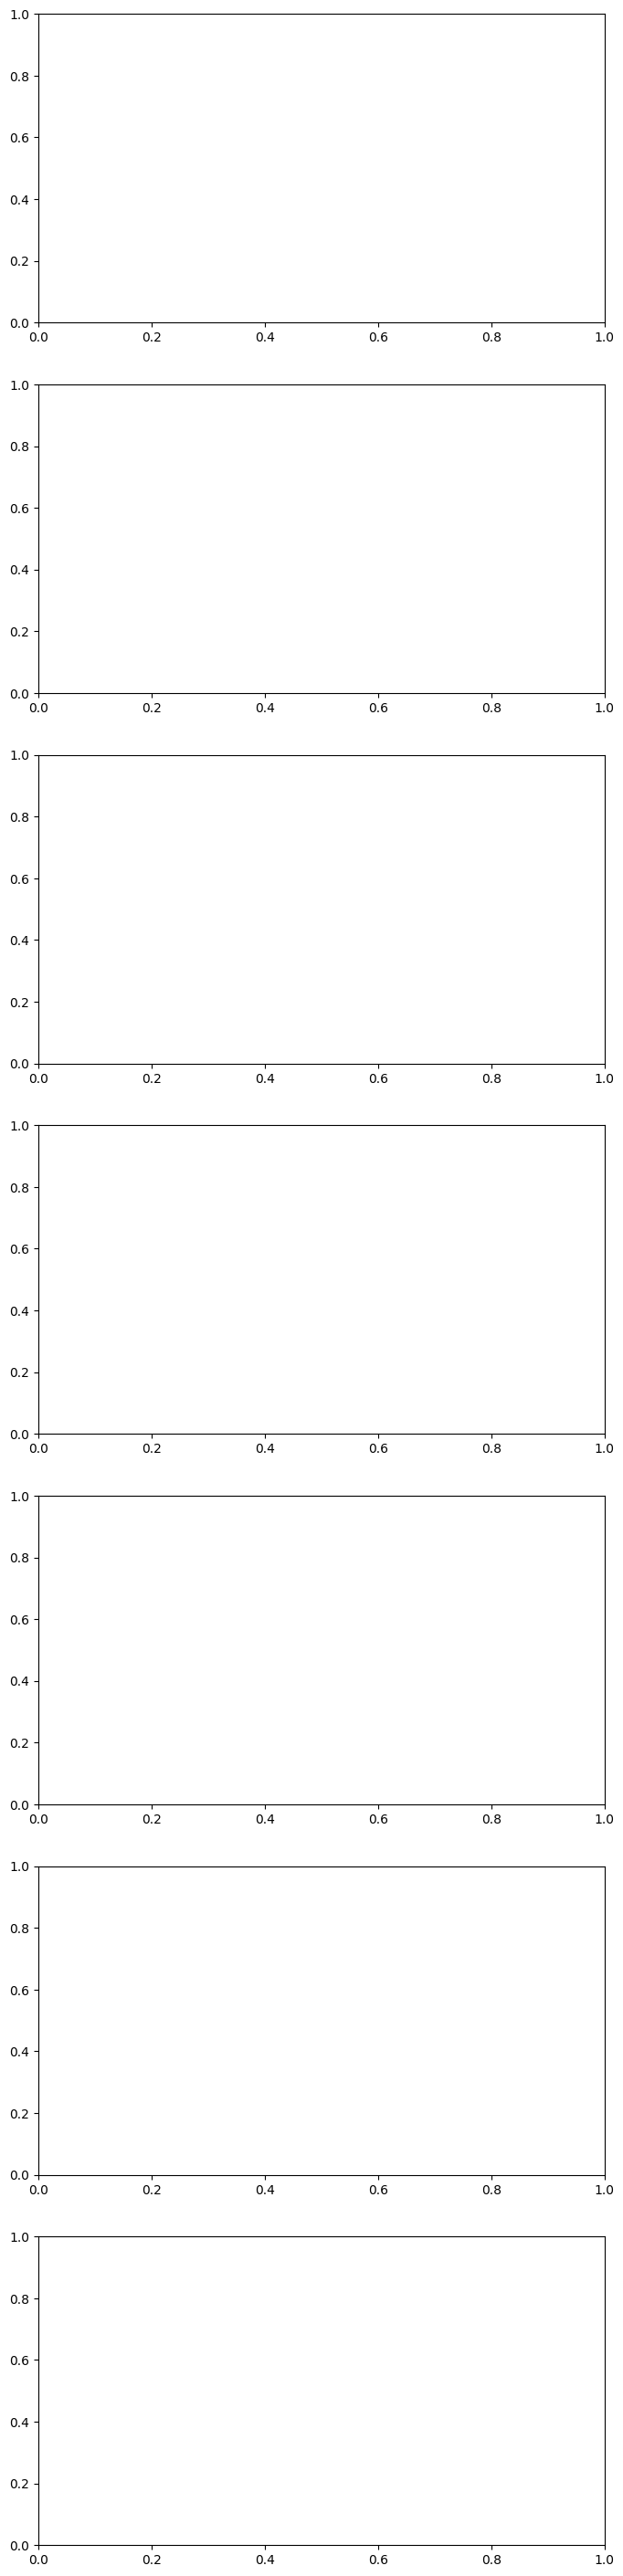

In [ ]:
if plot_cs:  
    # # NOTE: Plotting only works currently for som energies

    # Set up the values for plotting
    theta_vals = np.linspace(40, 140, 100)
    param_set = samples[:, :model.erp_dim]
    normalizations = samples[:, model.erp_dim:]

    # Plot every plot_skip-th parameter (This speeds up the calculation by a bit)
    plot_skip = 25
    param_set = param_set[::plot_skip]

    # Plotting energies are at the 'nominal' energies between the lowest and highest energy of the interaction regions
    plotting_energy_pool = np.array([0.691, 0.854, 1.2803, 1.750, 2.129, 2.6163, 2.6163, 3.592, 4.337, 5.4797])

    plot_numbers = np.where(plotting_energy_pool <= E_max)[0]

    # l_som_energies = np.array([[0.676, 0.84 , 1.269, 1.741, 2.12 , 2.609, 3.586, 4.332, 5.475],
    #                            [0.691, 0.854, 1.28 , 1.75 , 2.129, 2.616, 3.592, 4.337, 5.48 ],
    #                            [0.706, 0.868, 1.292, 1.759, 2.137, 2.624, 3.598, 4.342, 5.484]])

    print('Number of curves: {}\nNumber of figures: {}'.format(param_set.shape[0], plot_numbers.shape[0]))

    fig, ax = plt.subplots(plot_numbers.shape[0], 1, figsize = (8, 1 + 5 * int(plot_numbers.shape[0])))

    # Define an array for all the cross sections
    all_cs = np.empty((plot_numbers.shape[0], param_set.shape[0], theta_vals.shape[0]))

    # If we only have one set of data to plot, ax[0] is not iterable so we have to manually set this
    if plot_numbers.shape[0] == 1:
        # Handle single plotting...
        pass
    else:
        for selection in plot_numbers:
            for i in range(0, param_set.shape[0]):
                cs = []
                for theta in theta_vals:
                    cross_section = model.get_cs_theory(param_set[i], theta, plotting_energy_pool[selection]) * normalizations[i, selection]
                    all_cs[np.where(plot_numbers == selection)[0][0], i, np.where(theta_vals == theta)[0][0]] = cross_section
                    cs.append(cross_section)
                ax[selection].plot(theta_vals, cs)
                
            # Plot the data
            for energy in l_som_energies[:, selection]:
                indices = np.where(data[:, 1] == energy)
                tmp = data[indices]
                ax[selection].errorbar(tmp[:, 0], tmp[:, 2], yerr = tmp[:, 3], fmt = '.')

            
            ax[selection].set_xlabel('$\\theta$ [deg]')
            ax[selection].set_ylabel('CS [relative to Rutherford]')
            ax[selection].set_title('E = {:.4f} MeV'.format(plotting_energy_pool[selection]))

    fig.suptitle('E_min = {} MeV, E_max = {} MeV'.format(E_min, E_max))
    plt.tight_layout()
    plt.show()

In [ ]:
if plot_cs:  
    # # NOTE: Plotting only works currently for som energies

    # Set up the values for plotting
    theta_vals = np.linspace(40, 140, 100)
    param_set = samples[:, :model.erp_dim]
    normalizations = samples[:, model.erp_dim:]

    # Plot every plot_skip-th parameter (This speeds up the calculation by a bit)
    plot_skip = 25
    param_set = param_set[::plot_skip]

    # Plotting energies are at the 'nominal' energies between the lowest and highest energy of the interaction regions
    plotting_energy_pool = np.array([0.691, 0.854, 1.2803, 1.750, 2.129, 2.6163, 2.6163, 3.592, 4.337, 5.4797])

    plot_numbers = np.where(plotting_energy_pool <= E_max)[0]

    # l_som_energies = np.array([[0.676, 0.84 , 1.269, 1.741, 2.12 , 2.609, 3.586, 4.332, 5.475],
    #                            [0.691, 0.854, 1.28 , 1.75 , 2.129, 2.616, 3.592, 4.337, 5.48 ],
    #                            [0.706, 0.868, 1.292, 1.759, 2.137, 2.624, 3.598, 4.342, 5.484]])

    print('Number of curves: {}\nNumber of figures: {}'.format(param_set.shape[0], plot_numbers.shape[0]))

    fig, ax = plt.subplots(plot_numbers.shape[0], 1, figsize = (8, 1 + 5 * int(plot_numbers.shape[0])))

    # Define an array for all the cross sections
    all_cs = np.empty((plot_numbers.shape[0], param_set.shape[0], theta_vals.shape[0]))

    # If we only have one set of data to plot, ax[0] is not iterable so we have to manually set this
    if plot_numbers.shape[0] == 1:
        # Handle single plotting...
        pass
    else:
        for selection in plot_numbers:
            for i in range(0, param_set.shape[0]):
                cs = []
                for theta in theta_vals:
                    cross_section = model.get_cs_theory(param_set[i], theta, plotting_energy_pool[selection]) * normalizations[i, selection]
                    all_cs[np.where(plot_numbers == selection)[0][0], i, np.where(theta_vals == theta)[0][0]] = cross_section
                    cs.append(cross_section)
                ax[selection].plot(theta_vals, cs)
                
            # Plot the data
            for energy in l_som_energies[:, selection]:
                indices = np.where(data[:, 1] == energy)
                tmp = data[indices]
                ax[selection].errorbar(tmp[:, 0], tmp[:, 2], yerr = tmp[:, 3], fmt = '.')

            
            ax[selection].set_xlabel('$\\theta$ [deg]')
            ax[selection].set_ylabel('CS [relative to Rutherford]')
            ax[selection].set_title('E = {:.4f} MeV'.format(plotting_energy_pool[selection]))

    fig.suptitle('E_min = {} MeV, E_max = {} MeV'.format(E_min, E_max))
    plt.tight_layout()
    plt.show()